# Section 17: Python for Machine Learning: Logistic Regression 

### Logistic Regression Theory

In [1]:
## We want to learn about Logistic Regression as a method for Classification - The goal of classification is to 
## determine to which category a set of new observations belongs to.

## Some examples of classification problems: 
## 1 - Spam vs. 'Ham' problems 
## 2 - Loan Default (Yes/No)
## 3 - Disease Diagnosis -Has cancer or not? 

## All of the above examples are of Binary Classification - We have two classes. 

## ------------------------------------

## So far we've only seen Regression problems where we try to predict a continious value 
## Logitic Regression -> Allows us to solve classification problems -> We try to predict discrete categories. 
## Convention for binary classification -> We have two classes 0 and 1 

## ------------------------------------

## Linear Regression -> Bad fit when we have discrete categories -> Instead use a LR or Sigmoid hypotesis to 
## perform classification. 


## ------------------------------------

## Evaluating Classification models -> We can use a confusion matrix to evaluate/visualize classification models. 

### Logistic Regression with Python 

In [2]:
## We are going to be using the Titanic Dataset, we are going to tackle the following Classification problem: 

## Predict whether a passenger of the Titanic will survive or die (1/0) based on their features. 
## We are going to be using a semi-clean Titanic Dataset. 

## Kaggle -> Dataset hosting website -> We will obtain the data from here: Titanic: Machine Learning from Disaster 

In [4]:
## Imports 
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
%matplotlib inline

## Getting the Data
train = pd.read_csv('titanic_train.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


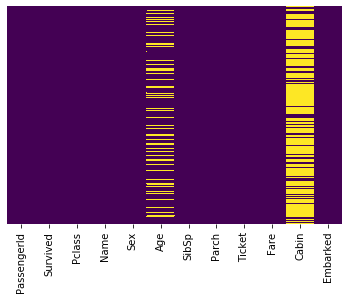

In [6]:
## Cleaning the Data 

## We are going to use seaborn to see where we are missing data: 

isnull= train.isnull() ##Use this boolean method to to transform our data into matrix form 

sns.heatmap(isnull, yticklabels = False, cbar = False, cmap = 'viridis')

In [7]:
### We can concude that we are mostly missing data from the Age and the Cabin columns. 
### Age data missing -> Around 20% -> Reasonable enough to use Imputation (Imputer) -> Using knowledge from other 
###                                   columns to fill in mising data.
### Cabin data -> Missing too much data to do something useful at a basic level. We can drop it later or change it to
###               another feature like cabin missing or something similar.

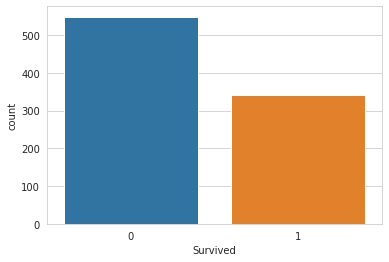

In [9]:
## More exploratory data analysis at a visual level.

sns.set_style('whitegrid')

##Always a good idea to see the ratio of the target label (survived / died)
sns.countplot(x = 'Survived', data = train)  

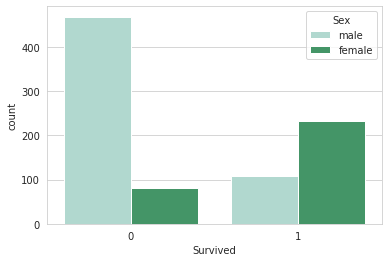

In [13]:
##Survival with a hue of sex 
sns.countplot(x = 'Survived', data = train, hue ='Sex', palette = 'BuGn')  

In [14]:
##Survival with a hue of passenger class
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

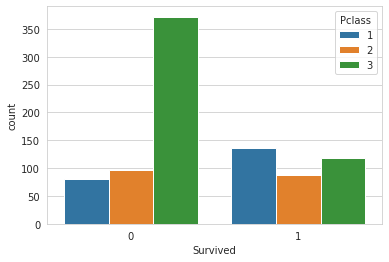

In [15]:
sns.countplot(x = 'Survived', data = train, hue = 'Pclass')

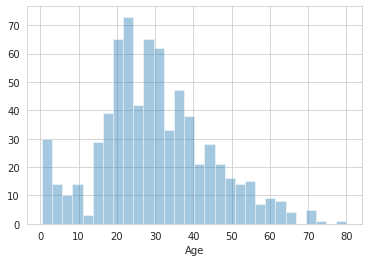

In [17]:
### Lets check out the distribution of ages 
sns.distplot(train['Age'].dropna(), kde = False, bins = 30) ##There is a small skew towards younger persons

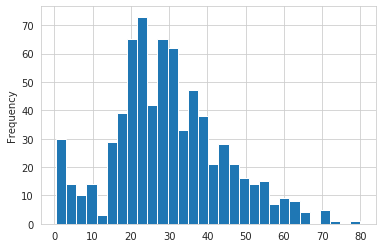

In [19]:
### We can do a similar plot with pandas directly 
train['Age'].plot(kind = 'hist', bins = 30)

In [20]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


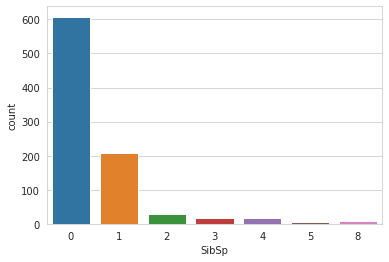

In [22]:
sns.countplot(x = 'SibSp', data = train) ##Most of the people didn't had a sibling/spouse onboard  

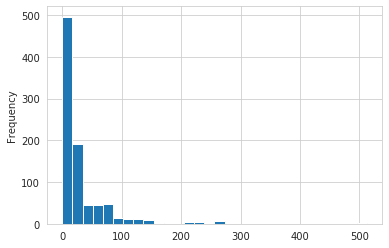

In [24]:
###Let's check the distribution of fares 
train['Fare'].plot(kind = 'hist', bins = 30)